# Variational Quantum Eigensolver using classical optimisers
### Estimation of ground state energy, Hamiltonian $H_{2}O$

In [1]:
#Import libraries
import torch
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
import numpy as np
from math import pi
import matplotlib.pylab as plt
from itertools import product
from qiskit.quantum_info import Operator
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(1, '../src/')
from utils.functions import *
from models.models_bo import *

from scipy.linalg import eigh
from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import TwoLocal


In [2]:
# Define the H2O molecule geometry
driver = PySCFDriver(
    atom="O 0 0 0; H 0.757 0.586 0; H -0.757 0.586 0",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)
# Run the driver to get the electronic structure problem
problem = driver.run()

#Obtaining the Hamiltonian
hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

#Converting to qubit Hamiltonian
mapper = JordanWignerMapper()
H = mapper.map(second_q_op)


nuclear_repulsion_energy = hamiltonian.nuclear_repulsion_energy
hamiltonian.electronic_integrals.alpha += PolynomialTensor({"": nuclear_repulsion_energy})
mapper = JordanWignerMapper()
second_q_op = hamiltonian.second_q_op()
H = mapper.map(second_q_op)


In [3]:
# Set up the initial state and, the UCCSD or TwoLocal ansatz for H2O
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles
mapper = JordanWignerMapper()

initial_state = HartreeFock(
    num_spatial_orbitals,
    num_particles,
    mapper
)


ansatz = UCCSD(
    num_spatial_orbitals=num_spatial_orbitals,
    num_particles=num_particles,
    qubit_mapper=mapper,
    initial_state=initial_state
    )

ansatz = TwoLocal(H.num_qubits, rotation_blocks="ry", entanglement_blocks="cz")
num_qubits = ansatz.num_qubits

print('Initial state:',Statevector.from_instruction(initial_state))
initial_circuit = ansatz.decompose()
print('Initial Circuit Ansatz')
#initial_circuit.draw('mpl')

Initial state: Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
Initial Circuit Ansatz


In [4]:
def create_circuit_ansatz(thetas, initial_state):

    # Create circuit
    circ = QuantumCircuit(ansatz.num_qubits)
    # Apply the initial state (HartreeFock)
    circ.compose(initial_state, inplace=True)
    # Apply the UCCSD ansatz with the generated parameters
    circ = ansatz.assign_parameters(thetas.squeeze()).compose(circ)
    return circ


n_thetas = ansatz.num_parameters
circ_visualization = create_circuit_ansatz(np.zeros(n_thetas)[np.newaxis,:], initial_state)
#circ_visualization.decompose().draw('mpl')

In [5]:
def target_function(thetas):
    circuit = create_circuit_ansatz
    new_exp_values, new_eigenvalue = get_expectation_values_hamiltonian(circuit, np.array(thetas)[np.newaxis,:], initial_state, H)
    return -new_eigenvalue  

In [6]:
#Estimate the ground state energy
#Due to the computational cost, we will not calculate the ground state energy and the value of −74.96, a value found in the literature, will be used.

ground_state_energy = -74.96
if False:
    eigenvalues, eigenvectors = eigh(H.to_matrix())
    ground_state_energy = np.min(eigenvalues)
    ground_state = eigenvectors[:, np.argmin(eigenvalues)]
print(f"Ground state energy: {ground_state_energy}")

Ground state energy: -74.96


# SPSA


In [7]:
n_run = 5
n_total_timesteps = 200

params = {'n_runs': n_run,
          'n_total_timesteps':n_total_timesteps,
         
         }

metrics = {
    'best_eigenvalue_runs': np.zeros(n_run),
    'history_best_eigenvalue_runs': np.zeros((n_run, n_total_timesteps)),
    'value_losses_runs':np.zeros((n_run,n_total_timesteps)),
    'best_thetas_runs': np.zeros((n_run,n_thetas)),
    }

for iter_run in range(n_run):
    print('run',iter_run+1)

    best_eigenvalue, eigenvalue_history = float('inf'), []
    best_thetas, thetas_history = np.zeros(n_thetas), []
    X_train, y_train = [], []
    
    def wrapper_objective_function(params):
        global best_eigenvalue
        global best_thetas

        y = target_function(params)
        X_train.append(params[0])
        y_train.append(y)

        if y<best_eigenvalue:
            best_eigenvalue = y
            best_thetas = params
        eigenvalue_history.append(best_eigenvalue)
        thetas_history.append(best_thetas)
        return y

    # Initialise the SPSA optimizer
    optimizer = SPSA(maxiter=n_total_timesteps//2)

    # Initial parameters for the circuit
    initial_params = np.random.rand(n_thetas)
    results = optimizer.minimize(
            wrapper_objective_function,
            x0=initial_params )

    #We only keep results until n_total_timesteps
    metrics['history_best_eigenvalue_runs'][iter_run,:] = np.array(eigenvalue_history)[:n_total_timesteps]
    metrics['best_eigenvalue_runs'][iter_run] = np.array(eigenvalue_history)[n_total_timesteps]
    best_thetas = np.array(thetas_history)[n_total_timesteps]
    metrics['best_thetas_runs'][iter_run,:] = best_thetas



y_train = np.array(y_train)[:n_total_timesteps]
X_train = np.array(X_train)[:n_total_timesteps]

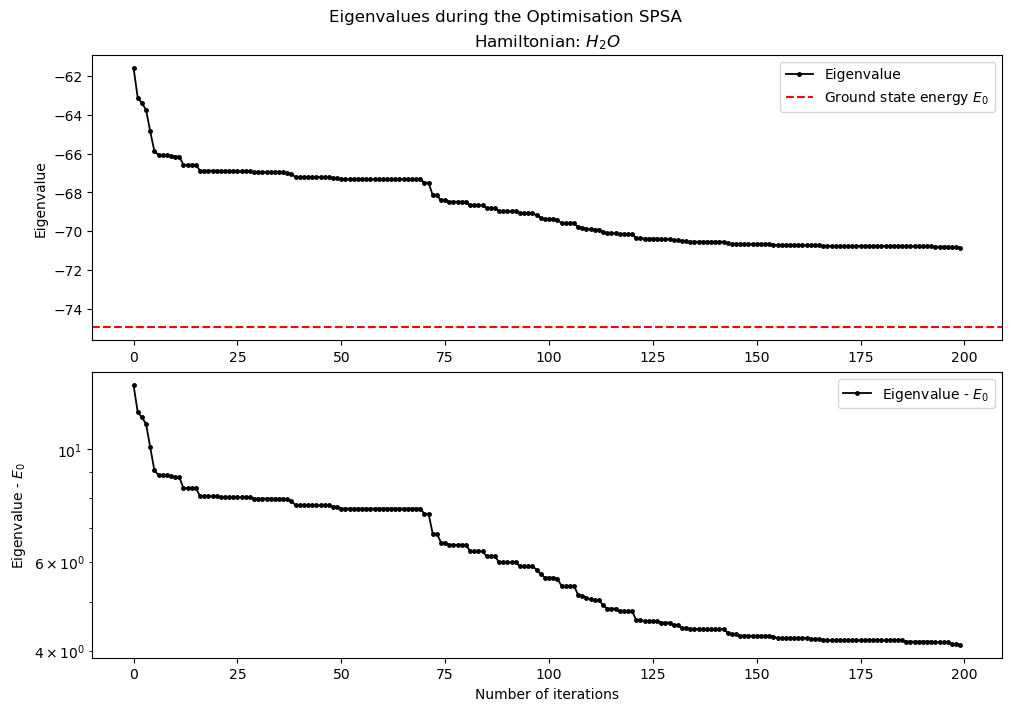

In [8]:
fig, ax = plt.subplots(2,1,figsize=(10,7), facecolor='white', constrained_layout = True, sharex=False, sharey=False)

plt.suptitle('Eigenvalues during the Optimisation SPSA')
ax[0].set_title(r'Hamiltonian: $H_{2}O$')
ax[0].plot(np.arange(n_total_timesteps), np.mean(metrics['history_best_eigenvalue_runs'],0), '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue')
ax[0].axhline(ground_state_energy, linestyle='--',color='r', label='Ground state energy $E_{0}$')

ax[1].plot(np.arange(n_total_timesteps), np.mean(metrics['history_best_eigenvalue_runs'],0) - ground_state_energy, '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue - $E_{0}$')
ax[1].set_yscale('log')
ax[0].set_ylabel('Eigenvalue')
ax[1].set_ylabel('Eigenvalue - $E_{0}$')
ax[1].set_xlabel('Number of iterations')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.legend()
plt.show()

In [9]:
data_plot = {   'history_best_eigenvalue_runs':metrics['history_best_eigenvalue_runs'],
                'best_thetas_runs': metrics['best_thetas_runs'],
                'best_eigenvalue_runs':metrics['best_eigenvalue_runs'],
                'real_ground_state_energy':ground_state_energy,

            } 
if True:
    with open("../results/vqe/results_hamiltonian_H2O_"+ str(num_qubits)+"qubits_spsa.json", "w") as outfile: 
        json.dump(data_plot, outfile, cls=CustomEncoder)

In [10]:
import mlflow
#Metrics resume
metrics_reg= {
    'mean_eigenvalue_runs': -np.mean(np.abs(metrics['best_eigenvalue_runs'])),
    'std_eigenvalue_runs': np.std(np.abs(metrics['best_eigenvalue_runs'])),
        }

params['size_final_dataset'] =  y_train.shape[0]

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VQE_H2O")

with mlflow.start_run(run_name='VQE_H2O_SPSA'):
    mlflow.log_params(params)
    mlflow.log_metrics(metrics_reg)
    

2024/09/29 19:01:01 INFO mlflow.tracking.fluent: Experiment with name 'VQE_H2O' does not exist. Creating a new experiment.
2024/09/29 19:01:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run VQE_H2O_SPSA at: http://127.0.0.1:8080/#/experiments/530387561206499386/runs/ea7c533b1be2489785a15c19fa416156.
2024/09/29 19:01:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/530387561206499386.


# L_BFGS_B

In [11]:
n_run = 5
n_total_timesteps = 200 

params = {'n_runs': n_run,
          'n_total_timesteps':n_total_timesteps,
         
         }

metrics = {
    'best_eigenvalue_runs': np.zeros(n_run),
    'history_best_eigenvalue_runs': np.zeros((n_run, n_total_timesteps)),
    'value_losses_runs':np.zeros((n_run,n_total_timesteps)),
    'best_thetas_runs': np.zeros((n_run,n_thetas)),
    }

for iter_run in range(n_run):
    print('run',iter_run+1)

    best_eigenvalue, eigenvalue_history = float('inf'), []
    best_thetas, thetas_history = np.zeros(n_thetas), []
    X_train, y_train = [], []
    
    def wrapper_objective_function(params):
        global best_eigenvalue
        global best_thetas

        y = target_function(params)
        X_train.append(params[0])
        y_train.append(y)

        if y<best_eigenvalue:
            best_eigenvalue = y
            best_thetas = params
        eigenvalue_history.append(best_eigenvalue)
        thetas_history.append(best_thetas)
        return y

    # Initialise the L_BFGS_B optimizer
    optimizer = L_BFGS_B(maxiter=n_total_timesteps//2)

    # Initial parameters for the circuit
    initial_params = np.random.rand(n_thetas)
    results = optimizer.minimize(
            wrapper_objective_function,
            x0=initial_params )

    #We only keep results until n_total_timesteps
    #LBFGS sometimes stop before n_total_timesteps
    if np.array(eigenvalue_history).shape[0]<=n_total_timesteps:
            fill_nan = np.nan*np.zeros(n_total_timesteps - np.array(eigenvalue_history).shape[0])
            metrics['history_best_eigenvalue_runs'][iter_run,:] = np.hstack((eigenvalue_history,fill_nan))
            metrics['best_eigenvalue_runs'][iter_run] = eigenvalue_history[-1]
            best_thetas = thetas_history[-1]
            metrics['best_thetas_runs'][iter_run,:] = best_thetas


    else:

        metrics['history_best_eigenvalue_runs'][iter_run,:] = np.array(eigenvalue_history)[:n_total_timesteps]
        metrics['best_eigenvalue_runs'][iter_run] = np.array(eigenvalue_history)[n_total_timesteps]
        best_thetas = np.array(thetas_history)[n_total_timesteps]
        metrics['best_thetas_runs'][iter_run,:] = best_thetas



y_train = np.array(y_train)[:n_total_timesteps]
X_train = np.array(X_train)[:n_total_timesteps]

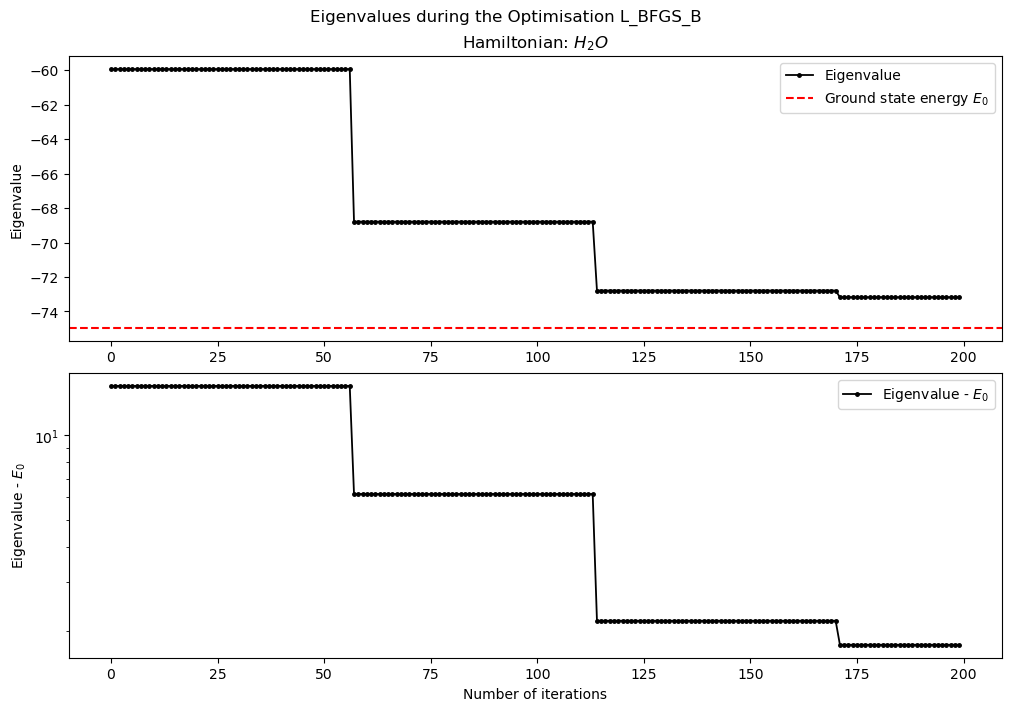

In [12]:
fig, ax = plt.subplots(2,1,figsize=(10,7), facecolor='white', constrained_layout = True, sharex=False, sharey=False)

plt.suptitle('Eigenvalues during the Optimisation L_BFGS_B')
ax[0].set_title(r'Hamiltonian: $H_{2}O$')
ax[0].plot(np.arange(n_total_timesteps), np.mean(metrics['history_best_eigenvalue_runs'],0), '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue')
ax[0].axhline(ground_state_energy, linestyle='--',color='r', label='Ground state energy $E_{0}$')

ax[1].plot(np.arange(n_total_timesteps), np.mean(metrics['history_best_eigenvalue_runs'],0) - ground_state_energy, '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue - $E_{0}$')
ax[1].set_yscale('log')
ax[0].set_ylabel('Eigenvalue')
ax[1].set_ylabel('Eigenvalue - $E_{0}$')
ax[1].set_xlabel('Number of iterations')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')


plt.legend()
plt.show()

In [13]:
data_plot = {   'history_best_eigenvalue_runs':metrics['history_best_eigenvalue_runs'],
                'best_thetas_runs': metrics['best_thetas_runs'],
                'best_eigenvalue_runs':metrics['best_eigenvalue_runs'],
                'real_ground_state_energy':ground_state_energy,

            } 
if True:
    with open("../results/vqe/results_hamiltonian_H2O_"+ str(num_qubits)+"qubits_lbfgsb.json", "w") as outfile: 
        json.dump(data_plot, outfile, cls=CustomEncoder)

Optionally: Track metrics and parameters in MLflow

In [14]:
import mlflow
#Metrics resume
metrics_reg= {
    'mean_eigenvalue_runs': -np.mean(np.abs(metrics['best_eigenvalue_runs'])),
    'std_eigenvalue_runs': np.std(np.abs(metrics['best_eigenvalue_runs'])),
        }

params['size_final_dataset'] =  y_train.shape[0]

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VQE_H2O")

with mlflow.start_run(run_name='VQE_H2O_LBFGSB'):
    mlflow.log_params(params)
    mlflow.log_metrics(metrics_reg)
    

2024/09/29 20:16:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run VQE_H2O_LBFGSB at: http://127.0.0.1:8080/#/experiments/530387561206499386/runs/554e0195a2614b6887a49ff8a97ebb6d.
2024/09/29 20:16:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/530387561206499386.
